In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import seaborn as sns
from scipy.stats import zscore
import optuna
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<Axes: >

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


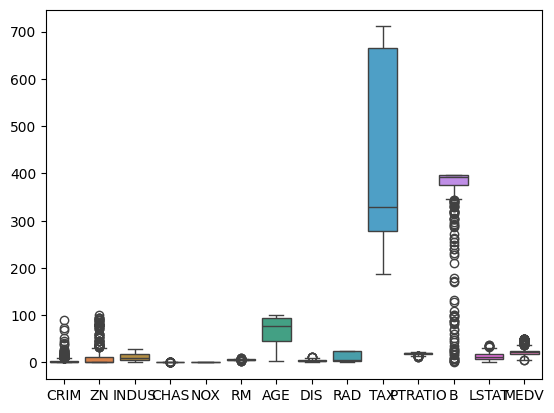

In [5]:
data = pd.read_csv("C:/Users/Administrator/Desktop/FinetuningOptuna/boston.csv")
sns.boxplot(data)
out = IForest(contamination=0.1)
out_pred = out.fit_predict(data)
std_data = data[out_pred == 1]

<Axes: >

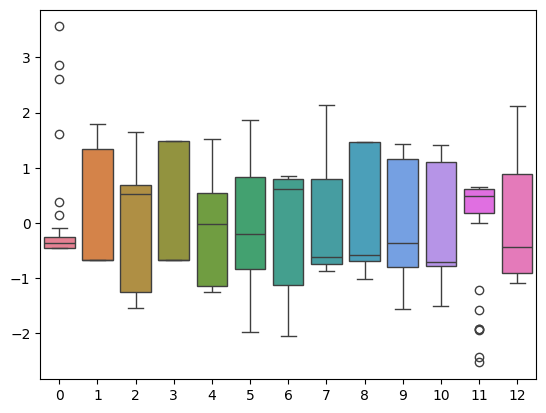

In [6]:
X = std_data.drop("MEDV", axis = 1)
y = std_data["MEDV"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sns.boxplot(X_train_scaled)


In [17]:
model = GradientBoostingRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


0.07705325081936054

8.751195800934806

In [33]:
def objective(trial):
    hiper = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber']),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.1),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.01),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.01),
        'alpha': trial.suggest_float('alpha', 0.1, 0.9) if trial.params.get('loss') in ['huber', 'quantile'] else 0.9,
        'random_state': 369,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'tol': 1e-4
    }
    model = GradientBoostingRegressor(**hiper)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = r2_score(y_test, y_pred)
    return acc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=1000)

[I 2025-08-24 20:22:10,975] A new study created in memory with name: no-name-3109968a-52c8-48fd-b28f-52af6fc3730e
[I 2025-08-24 20:22:11,206] Trial 0 finished with value: -0.045491079962943326 and parameters: {'n_estimators': 366, 'learning_rate': 0.25941035159120696, 'max_depth': 7, 'loss': 'huber', 'subsample': 0.6191566849711282, 'min_samples_split': 14, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.07766195630048969, 'criterion': 'friedman_mse', 'max_features': 'log2', 'min_impurity_decrease': 0.004724918045453337, 'ccp_alpha': 0.001596314772851245, 'alpha': 0.7022886072950809}. Best is trial 0 with value: -0.045491079962943326.
[I 2025-08-24 20:22:11,427] Trial 12 finished with value: 0.5862892168156246 and parameters: {'n_estimators': 371, 'learning_rate': 0.07631150822034899, 'max_depth': 9, 'loss': 'squared_error', 'subsample': 0.9798011611443063, 'min_samples_split': 8, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0015568672339093981, 'criterion': 'friedman_mse

,loss,'huber'
,learning_rate,0.2986767662868708
,n_estimators,323
,subsample,0.7619910113446069
,criterion,'squared_error'
,min_samples_split,10
,min_samples_leaf,3
,min_weight_fraction_leaf,0.00903246562271474
,max_depth,7
,min_impurity_decrease,0.004343385390483593
,init,None


0.7241710200876539

5.395226619852307

<Axes: xlabel='MEDV'>

Text(0.5, 0, 'Y_true')

Text(0, 0.5, 'Y_pred')

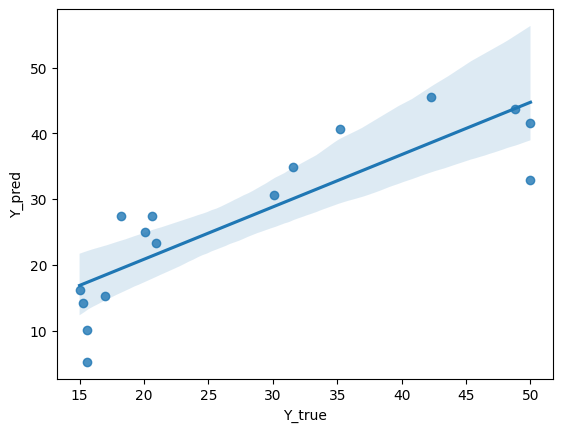

In [43]:
model = GradientBoostingRegressor(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Y_true")
plt.ylabel("Y_pred")